# **Project 1 − Cosmological Models**
## Advanced Simulation and Machine Learning | TIF345
## Chalmers University of Technology | Fall 2025
---
### Linus Brink | [brinkl@chalmers.se](mailto:brinkl@chalmers.se) 
### Oscar Stommendal | [oscarsto@chalmers.se](mailto:oscarsto@chalmers.se)
---

In [ ]:
### Imports and plotting settings ###

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import integrate, optimize, stats


plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

def running_mean(x, factor):
    """
    Return the running mean of N element in a list.

    Args:
        x (ndarray): The list of elements,
        factor (float): The factor to multiply the length of the list by.
    
    Returns:
        ndarray: The running mean.
    """
    it, walker = x.shape
    N = int(factor * it)
    average = np.zeros((it - N+1,walker))
    #print(average.shape)
    for i in range(walker):
        cumsum = np.cumsum(np.insert(x[:,i], 0, 0))
        #print((cumsum[N:] - cumsum[:-N]).shape)
        average[:,i] = ((cumsum[N:] - cumsum[:-N]) / float(N))
    average = np.sum(average,axis=1) / walker

    return average

def trace_plotter(axs, sampler, iterations, sampler_idx=None, ndim=2, save=False):
    """
    Plot the traces of the MCMC chain.

    Args:
        axs (ndarray): The axes to plot on,
        sampler (emcee.EnsembleSampler): The sampler object,
        iterations (int): The number of iterations to plot,
        sampler_idx (str): The index of the sampler,
        ndim (int): The number of dimensions of the parameter space,
        save (bool): Whether to save the figure.
    """
    
    # If we have three parameters, plot the trace of sigma as well
    if ndim == 3:
        axs[2].plot([], [], 'k')
        axs[2].plot(running_mean(sampler.chain[:, :iterations, 2].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)
        axs[2].plot(sampler.chain[:, :iterations, 2].T, color='k', alpha=0.3)
        axs[2].plot(running_mean(sampler.chain[:, :iterations, 2].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)
        axs[2].set_ylabel(r'$\sigma_{\mathrm{sys}}^2$')
        axs[2].set_xlabel('Sampler Iteration')
        axs[2].legend(['Traces','Rolling averages'], loc = 'lower center', bbox_to_anchor=(0.47, -0.55), ncol=2)
    # If we have two parameters, plot the traces of H0 and q0
    else:
        axs[1].set_xlabel('Sampler Iteration')
    # Plot the traces and running means of H0 and q0
    axs[0].plot([], [], 'k')
    axs[0].plot(running_mean(sampler.chain[:, :iterations, 0].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    axs[0].plot(sampler.chain[:, :iterations, 0].T, color='k', alpha=0.1)#, label='Traces $c_D$')
    axs[0].plot(running_mean(sampler.chain[:, :iterations, 0].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    axs[0].set_ylabel(r'$H_0$')
    axs[0].set_xticklabels([])
    axs[1].plot([], [], 'k')
    axs[1].plot(running_mean(sampler.chain[:, :iterations, 1].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    axs[1].plot(sampler.chain[:, :iterations, 1].T, color='k', alpha=0.1)#, label='Traces $c_E$')
    axs[1].plot(running_mean(sampler.chain[:, :iterations, 1].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    axs[1].set_ylabel(r'$q_0$')
    axs[1].set_ylabel(r'$\Omega_{0,M}$')
    axs[1].set_xticklabels([])

    if save:
        axs[0].figure.savefig('figs/post_samples'+sampler_idx+'.png', bbox_inches='tight', dpi=1000)


## **Task 1: Infer $H_0$ and $q_0$ based on the data set**

In [113]:
### Read data and define simulation parameters ###

data = np.loadtxt("data/SCPUnion2.1_mu_vs_z.txt", comments="#", usecols=(1,2,3,4))
z = data[:, 0] # redshift
z_05 = z[z < 0.5]
mu_obs = data[:, 1] # observed distance modulus
mu_obs_05 = mu_obs[z < 0.5]
mu_err = data[:, 2] # error in distance modulus
mu_err_05 = mu_err[z < 0.5]
data_sys = data[:, 3] # systematic error in distance modulus

c = 299792.458 # speed of light in km/s
H0_min, H0_max = 30, 100 # Hubble constant prior range in km/s/Mpc
q0_min, q0_max = -10, 10 # Deceleration parameter prior range
inv_gamma_a = 1.0 # inverse gamma parameter for systematic error model
inv_gamma_scale = 1.0 # inverse gamma scale for systematic error model

# Very-low-z H0 sanity check
mini_mask = z < 0.05
d_L = (10**((mu_obs[mini_mask] + 5) / 5)) / 1e6  # in Mpc
H_0 = c * z[mini_mask] / d_L
print(f"Estimated H0 from very low-z data: {np.median(H_0):.2f} ± {np.std(H_0):.2f} km/s/Mpc")


Estimated H0 from very low-z data: 68.31 ± 5.75 km/s/Mpc


In [114]:
def mu_theory(z, H0, q0, c):
    """Distance modulus using the small-z approximation."""
    dL_MPc = c / H0 * (z + 0.5 * (1 - q0) * z**2)
    mu = 5 * np.log10(dL_MPc) + 25
    return mu

def log_prior(theta):
    """Calculate the log prior probability for the parameters."""
    H0, q0, sigma2 = theta
    if H0_min < H0 < H0_max and q0_min < q0 < q0_max and sigma2 > 0:
        return stats.invgamma.logpdf(sigma2, a=inv_gamma_a, scale=inv_gamma_scale)
    return -np.inf

def log_likelihood(theta, z, mu_obs, mu_err):
    H0, q0, sigma2 = theta
    if sigma2 <= 0:
        return -np.inf
    mu_model = mu_theory(z, H0, q0, c)
    if np.any(~np.isfinite(mu_model)):
        return -np.inf
    var = sigma2 * mu_err**2
    if np.any(var <= 0):
        return -np.inf
    logpdf = stats.norm.logpdf(mu_obs, loc=mu_model, scale=np.sqrt(var))
    if np.any(~np.isfinite(logpdf)):
        return -np.inf
    return np.sum(logpdf)

def log_posterior(theta, z, mu_obs, mu_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, z, mu_obs, mu_err)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


In [164]:
### Run MCMC ###

ndim = 3
nwalkers = 100

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = 70.0 + 10 * np.random.randn(nwalkers)  # H0
p0[:,1] = -0.5 + 0.2 * np.random.randn(nwalkers)  # q0 (start near negative)
p0[:,2] = stats.invgamma.rvs(inv_gamma_a, scale=inv_gamma_scale, size=nwalkers)  # σ²

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_05, mu_obs_05, mu_err_05))
print("Running burn-in...")
pos, prob, state = sampler.run_mcmc(p0, 1000, progress=True)

sampler.reset()

print("Running production...")
sampler.run_mcmc(pos, 5000, progress=True)

samples = sampler.get_chain(flat=True)
H0_samples = samples[:, 0]
q0_samples = samples[:, 1]
sigma2_samples = samples[:, 2]


Running burn-in...


100%|██████████| 1000/1000 [00:41<00:00, 24.36it/s]


Running production...


100%|██████████| 5000/5000 [03:09<00:00, 26.42it/s]


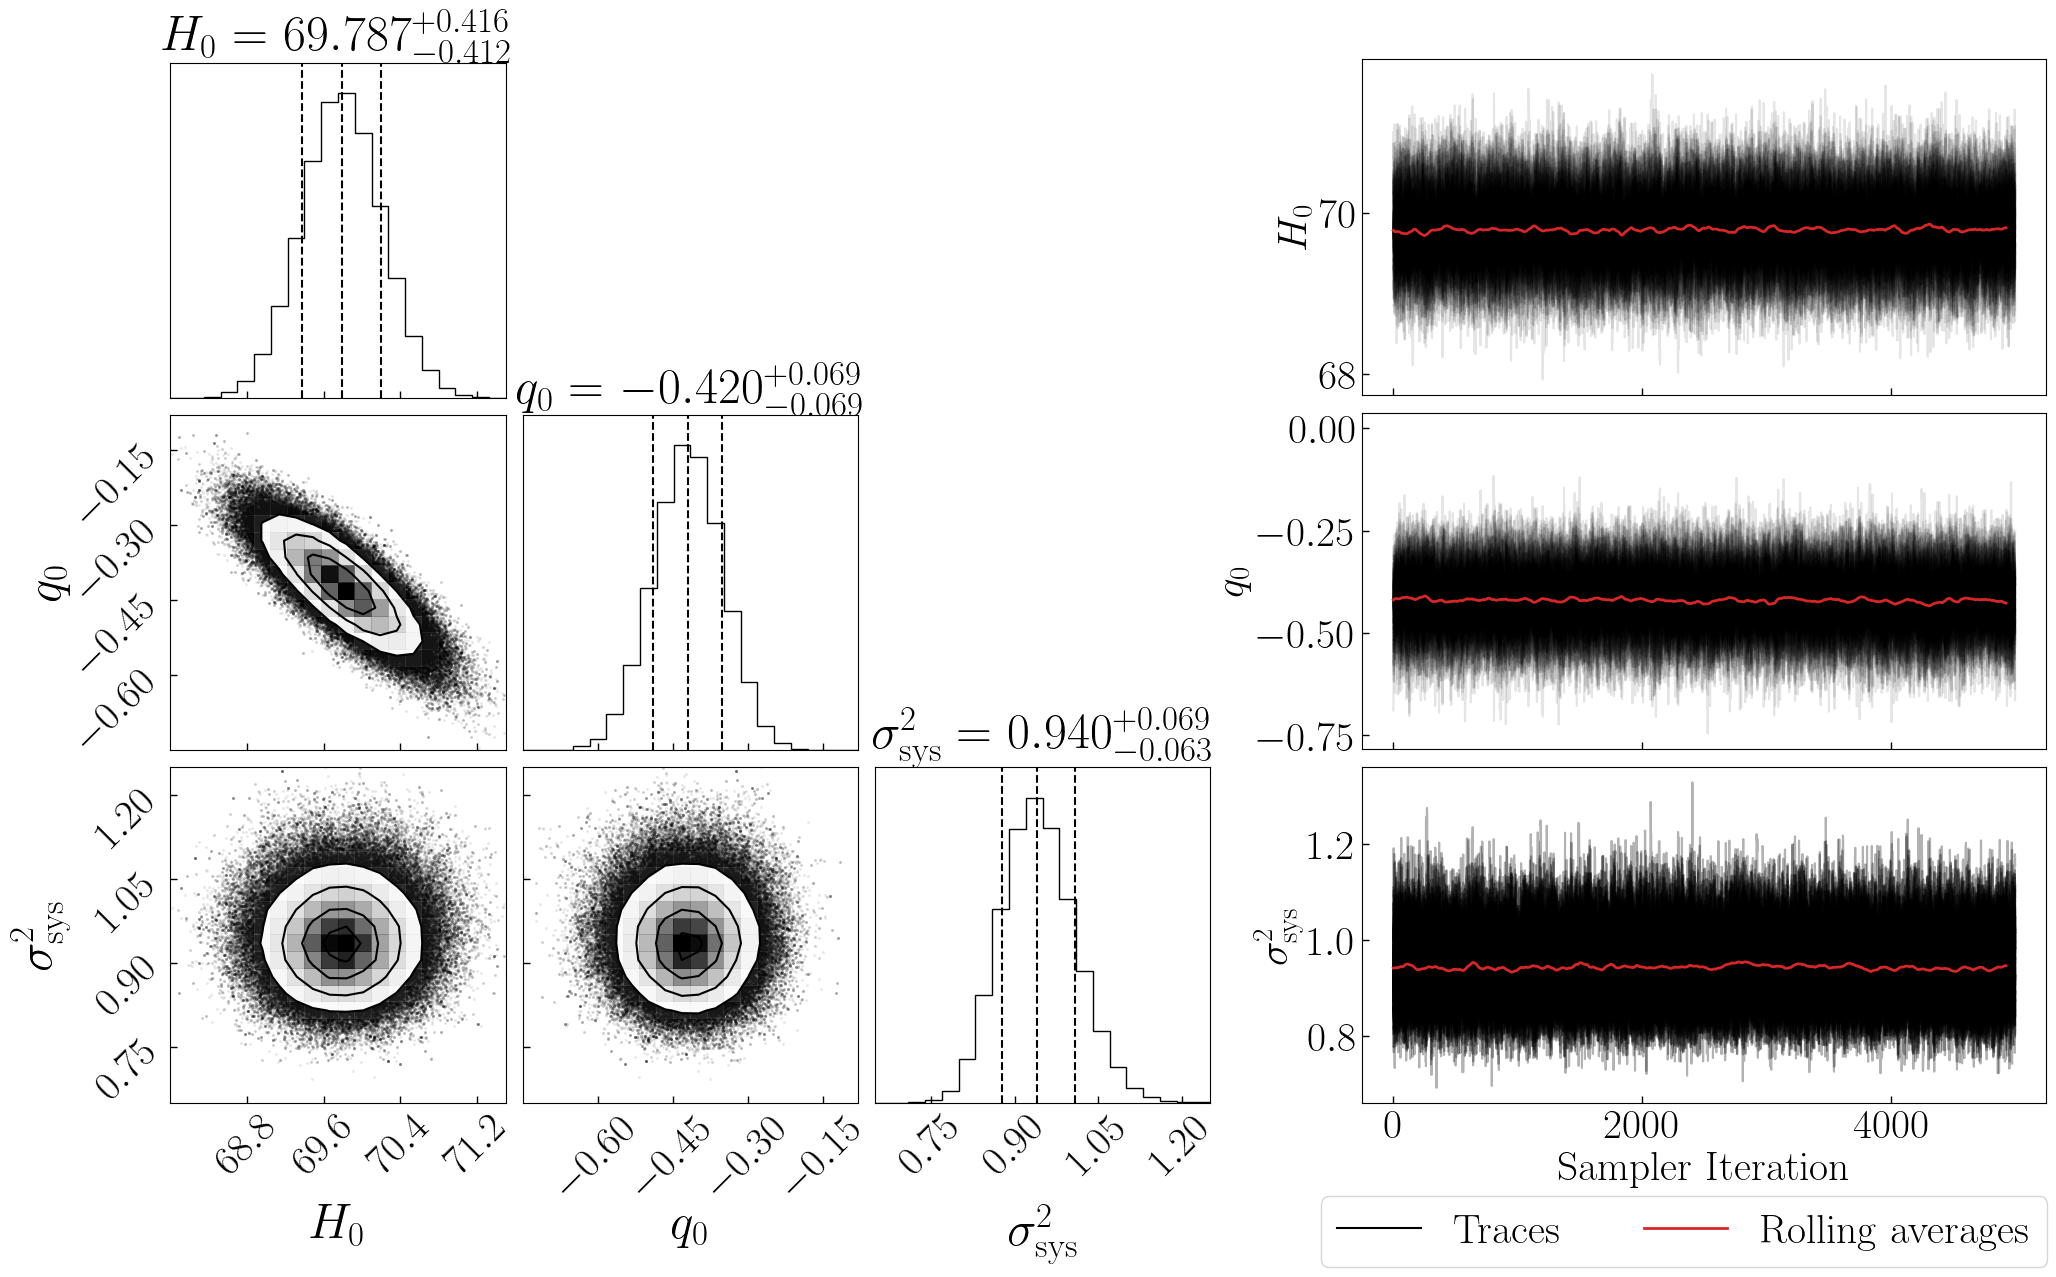

In [ ]:
### Results ###

# Corner plot
fig = corner.corner(np.vstack([H0_samples, q0_samples, sigma2_samples]).T,
                    labels=[r"$H_0$", r"$q_0$", r"$\sigma_{\mathrm{sys}}^2$"],
                    range=[[68, 71.5], [-0.75, -0.08], [0.65, 1.25]],
                    show_titles=True,
                    title_fmt=".3f",
                    quantiles=[0.16, 0.5, 0.84],
                    label_kwargs={"fontsize": font_size+6})
fig.subplots_adjust(right=1.5,top=1.5)
fig.savefig("posterior_corner.png")
fig.add_axes([1.7, 1.063, 0.9, 0.442])
fig.add_axes([1.7, 0.597, 0.9, 0.442])
fig.add_axes([1.7, 0.131, 0.9, 0.442])
axs = fig.get_axes()[-3:]

trace_plotter(axs, sampler, iterations=5000, sampler_idx="_H0_q0_sigma2", ndim=3, save=False)

# fig_2 = plt.figure(figsize=(6,5))
# plt.hist2d(H0_samples, q0_samples, bins=50, density=True, cmap='Blues')
# plt.colorbar(label='Density')
# plt.xlabel(r'$H_0$')
# plt.ylabel(r'$q_0$')
# plt.title('Joint Posterior Distribution of $H_0$ and $q_0$')
# plt.tight_layout()
# # plt.savefig('figs/joint_posterior_H0_q0.pdf')
# plt.show()


In [182]:
### Posterior predictive plot of distance modulus ###

z_plot = np.linspace(0.01, 1.5, 100)
mu_model_samples = np.array([mu_theory(z_plot, H0, q0, c) for H0, q0 in zip(H0_samples, q0_samples)])
mu_model_median = np.median(mu_model_samples, axis=0)


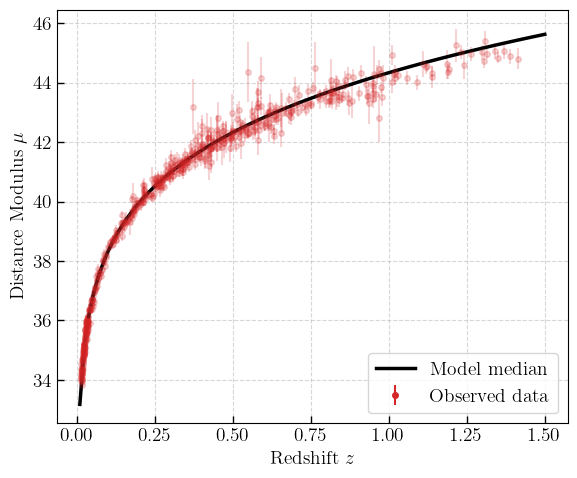

In [ ]:

plt.figure(figsize=(6,5))

plt.errorbar(z, mu_obs, yerr=mu_err, fmt='o', alpha=0.2, color='tab:red', markersize=4)
plt.plot(z_plot, mu_model_median, color='k', label='Model median', linewidth=2.5)
plt.errorbar([], [], yerr=[], label='Observed data', color='tab:red', fmt='o', markersize=4)
plt.xlabel("Redshift $z$")
plt.ylabel("Distance Modulus $\\mu$")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig('figs/mu_model_pred.pdf')
plt.show()

## **Task 2: Cosmological Models Comparison**

In [8]:

# Bounds for optimizer
H0_bounds = (30.0, 100.0)
Om_bounds = (0.0, 1.0)
w_bounds = (-3.0, 1.0)

# Model utilities
def E_sqrt_z(zp, Om, w):
    Ol = 1.0 - Om
    return np.sqrt(Om * (1 + zp)**3 + Ol * (1 + zp)**(3 * (1 + w)))

def dL_Mpc(H0, Om, w, z):
    # dL = c (1+z) * integral_0^z dz' / H(z')  ; H(z) = H0 * E_sqrt_z
    # so dL = (c/H0) (1+z) * integral_0^z dz' / E(z')
    def integrand(zp):
        return 1.0 / E_sqrt_z(zp, Om, w)
    I = np.array([integrate.quad(integrand, 0.0, zi, epsabs=1e-8, epsrel=1e-8)[0] for zi in np.atleast_1d(z)])
    return (c / H0) * (1.0 + np.atleast_1d(z)) * I

def mu_model(theta, z, model="wCDM"):
    # Theta: for wCDM [H0, Om, w], for LCDM [H0, Om]
    if model == "LCDM":
        H0, Om = theta
        w = -1.0
    else:
        H0, Om, w = theta
    dL = dL_Mpc(H0, Om, w, z)
    mu = 5.0 * np.log10(dL) + 25.0
    return mu

# Likelihood/objective
def neg_loglike_theta(theta, z, mu_obs, sigma, model):
    mu_pred = mu_model(theta, z, model=model)
    
    # include normalization constant for likelihood (useful for AIC/BIC via logL)
    logL = stats.norm.logpdf(mu_obs, loc=mu_pred, scale=sigma).sum()
    return -logL  # we minimize negative log-likelihood

# AIC/BIC helpers
def compute_ic(logL_max, k, n):
    aic = - 2 * k + 2 * logL_max
    bic = - k * np.log(n) + 2 * logL_max
    return aic, bic

N = len(z)

# Fit LCDM (k=2 parameters: H0, Om)
k_lcdm = 2
x0 = np.array([70.0, 0.3])
bounds_lcdm = [H0_bounds, Om_bounds]

res_lcdm = optimize.minimize(neg_loglike_theta, x0, args=(z, mu_obs, mu_err, "LCDM"), bounds=bounds_lcdm, method="nelder-mead")

theta_lcdm = res_lcdm.x
neglogL_lcdm = res_lcdm.fun
logL_lcdm = -neglogL_lcdm
aic_lcdm, bic_lcdm = compute_ic(logL_lcdm, k_lcdm, N)

# Fit wCDM (k=3 parameters: H0, Om, w)
k_wcdm = 3
x0 = np.array([70.0, 0.3, -1.0])
bounds_wcdm = [H0_bounds, Om_bounds, w_bounds]

res_wcdm = optimize.minimize(neg_loglike_theta, x0, args=(z, mu_obs, mu_err, "wCDM"), bounds=bounds_wcdm, method="nelder-mead")

theta_wcdm = res_wcdm.x
neglogL_wcdm = res_wcdm.fun
logL_wcdm = -neglogL_wcdm
aic_wcdm, bic_wcdm = compute_ic(logL_wcdm, k_wcdm, N)

# --- report ---
def print_result(name, theta, aic, bic):
    print(f"\n{name} best-fit:")
    if name == "LCDM":
        print(f"  H0 = {theta[0]:.3f}  Om = {theta[1]:.3f}")
    else:
        print(f"  H0 = {theta[0]:.3f}  Om = {theta[1]:.3f}  w = {theta[2]:.3f}")
    print(f"  AIC = {aic:.3f}")
    print(f"  BIC = {bic:.3f}")

print_result("LCDM", theta_lcdm, aic_lcdm, bic_lcdm)
print_result("wCDM", theta_wcdm, aic_wcdm, bic_wcdm)



LCDM best-fit:
  H0 = 70.002  Om = 0.278
  AIC = 233.481
  BIC = 224.755

wCDM best-fit:
  H0 = 70.018  Om = 0.281  w = -1.010
  AIC = 231.483
  BIC = 218.394


In [9]:

Om_grid = np.linspace(0.0, 0.5, 100)
w_grid = np.linspace(-1.5, 0., 100)

likelihood = np.zeros((len(Om_grid), len(w_grid)))
for i, Om in enumerate(Om_grid):
    for j, w in enumerate(w_grid):
        theta = [70.0, Om, w]
        neglogL = neg_loglike_theta(theta, z, mu_obs, mu_err, "wCDM")
        likelihood[i, j] = np.exp(-neglogL)


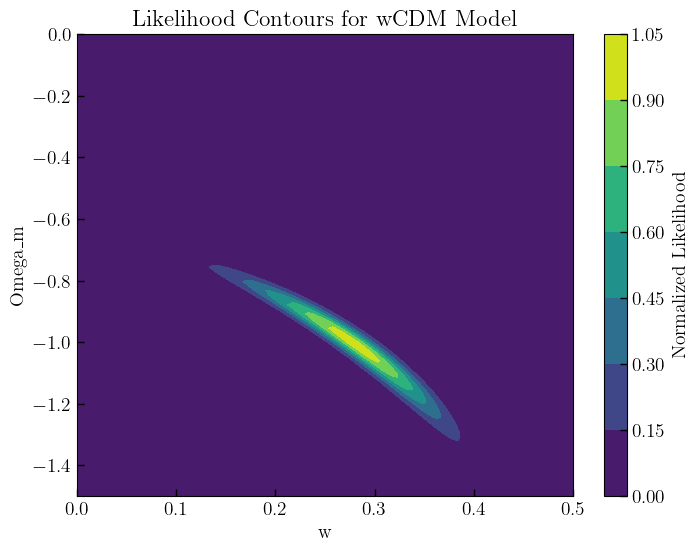

In [ ]:

plt.figure(figsize=(8,6))
Om_mesh, w_mesh = np.meshgrid(Om_grid, w_grid, indexing='ij')
plt.contourf(Om_mesh, w_mesh, likelihood / np.max(likelihood))
plt.colorbar(label='Normalized Likelihood')
plt.xlabel('Omega_m')
plt.ylabel('w')
plt.title('Likelihood Contours for wCDM Model')
plt.show()

In [243]:

def log_prior(Om):
    if 0.0 < Om < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(Om, z, mu_obs, mu_err):

    return -neg_loglike_theta([70.0, Om], z, mu_obs, mu_err, "LCDM")

def log_posterior(Om, z, mu_obs, mu_err):
    lp = log_prior(Om)  # Om is the second parameter
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(Om, z, mu_obs, mu_err)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


In [244]:

H0 = 70.0

ndim = 1  # Only Om
nwalkers = 10

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = 0.3 + 0.1 * np.random.randn(nwalkers)

sampler_Om = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, mu_obs, mu_err))
print("Running MCMC for Om in LCDM...")
pos, prob, state = sampler_Om.run_mcmc(p0, 100, progress=True)
sampler_Om.reset()

print("Running production...")
sampler_Om.run_mcmc(pos, 1000, progress=True)
samples = sampler_Om.get_chain(flat=True)
Om_samples = samples[:, 0]


Running MCMC for Om in LCDM...


100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


Running production...


100%|██████████| 1000/1000 [31:44<00:00,  1.90s/it] 


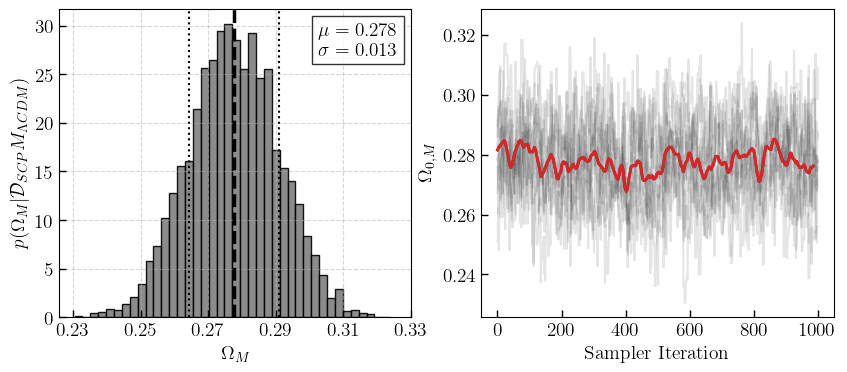

In [ ]:
### Plot marginal posterior for Omega_M ###

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
axs[0].hist(Om_samples, bins=40, density=True, color='tab:gray', alpha=0.9, edgecolor='black')
axs[0].axvline(np.mean(Om_samples), color='k', linestyle='--', linewidth=2.5)
axs[0].axvline(np.mean(Om_samples) - np.std(Om_samples), color='k', linestyle=':', linewidth=1.5)
axs[0].axvline(np.mean(Om_samples) + np.std(Om_samples), color='k', linestyle=':', linewidth=1.5)
axs[0].set_xlabel(r"$\Omega_M$")
axs[0].set_ylabel("$p(\\Omega_M | \\mathcal{D}_{SCP}M_{\\Lambda CDM})$")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].set_xticks([0.23, 0.25, 0.27, 0.29, 0.31, 0.33])
axs[0].text(0.3025, 27, f"$\\mu = {np.mean(Om_samples):.3f}$\n$\\sigma = {np.std(Om_samples):.3f}$", fontsize=14, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

trace_plotter(axs, sampler_Om, iterations=1000, sampler_idx="_Om_LCDM", ndim=1, save=False)

plt.show()